# SAM3 Gripper 分割（Session 2）

**运行顺序**：`mask_config.yaml` → imports → config → init → [Gripper 标注 UI] → Session 2 Gripper 分割 → cleanup

- 仅使用标注点（JSON）初始化，不依赖 arm session
- 分割结果保存到 checkpoint（`_ckpt_gripper` 目录）
- 与 `mask_1_arm.ipynb` 完全独立，可任意顺序运行
- 运行完成后在 `mask_3_merge.ipynb` 中合并


In [1]:
# imports

# ============================================================
# Imports
# ============================================================
%load_ext autoreload
%autoreload 2

import json
import os
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import yaml
from PIL import Image

import sam3
from sam3.model_builder import build_sam3_video_predictor

from mask_pipeline_tools import (
    add_text_prompt,
    apply_prompt_list,
    cleanup_process_group,
    cleanup_resources,
    get_frame_size,
    iter_object_masks_from_frame_output,
    load_video_frames_for_visualization,
    propagate_bidirectional_and_merge,
    validate_and_normalize_prompt_list,
    visualize_outputs,
)
from annotation_ui_tools import (
    create_annotation_store,
    create_annotation_ui,
    load_annotation_prompts_json,
    seed_store_from_prompt_map,
)

plt.rcParams["axes.titlesize"] = 12
plt.rcParams["figure.titlesize"] = 12

/home/haoxiang/sam3/sam3/model_builder.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
# 配置加载

# ============================================================
# 配置加载 — 修改 mask_config.yaml 来调整参数
# ============================================================
import yaml

_CONFIG_PATH = Path("mask_config.yaml")
with open(_CONFIG_PATH, "r") as _f:
    _cfg = yaml.safe_load(_f)

TASK_NAME = _cfg['task_name']
SCENE_NAME = _cfg['scene_name']
CHECKPOINT_PATH = _cfg['sam3_checkpoint']
CUDA_VISIBLE_DEVICES = _cfg['cuda_visible_devices']
APPLY_TEMPORAL_DISAMBIGUATION = bool(_cfg['apply_temporal_disambiguation'])
ARM_OBJ_ID = int(_cfg['arm_obj_id'])
ARM_OBJ_ID_2 = int(_cfg['arm_obj_id_2']) if _cfg.get('arm_obj_id_2') is not None else None
GRIPPER_LEFT_OBJ_ID = int(_cfg['gripper_left_obj_id'])
GRIPPER_RIGHT_OBJ_ID = int(_cfg['gripper_right_obj_id'])
ARM_TEXT_PROMPT = _cfg['arm_text_prompt']
ARM_TEXT_BOOTSTRAP_FRAME_INDEX = int(_cfg['arm_text_bootstrap_frame_index'])
VIS_FRAME_STRIDE = int(_cfg['vis_frame_stride'])
VIS_MAX_PLOTS = int(_cfg['vis_max_plots'])
EXPORT_ARM_DILATE_RADIUS = int(_cfg['export_arm_dilate_radius'])
EXPORT_GRIPPER_DILATE_RADIUS = int(_cfg['export_gripper_dilate_radius'])
EXPORT_LOG_EVERY = int(_cfg['export_log_every'])

# Derived paths
_data_base = _cfg['data_base_dir']
_export_base_str = _cfg['export_base_dir']
VIDEO_PATH = f"{_data_base}/{TASK_NAME}/train/{SCENE_NAME}/cam_105422061350/color"
ANNOTATION_JSON_PATH = str(Path(VIDEO_PATH).parent / "annotation_prompts_gripper_points.json")
ARM_ANNOTATION_JSON_PATH = str(Path(VIDEO_PATH).parent / "annotation_prompts_arm_points.json")
EXPORT_OUTPUT_DIR = f"{_export_base_str}/{TASK_NAME}/{SCENE_NAME}"
_export_base = Path(EXPORT_OUTPUT_DIR)
CHECKPOINT_ARM_DIR     = str(_export_base.parent / (_export_base.name + "_ckpt_arm"))
CHECKPOINT_GRIPPER_DIR = str(_export_base.parent / (_export_base.name + "_ckpt_gripper"))

print(f"[config] task={TASK_NAME}  scene={SCENE_NAME}")
print(f"[config] VIDEO_PATH={VIDEO_PATH}")
print(f"[config] ANNOTATION_JSON_PATH={ANNOTATION_JSON_PATH}")
print(f"[config] ARM_ANNOTATION_JSON_PATH={ARM_ANNOTATION_JSON_PATH}")
print(f"[config] CHECKPOINT_ARM_DIR={CHECKPOINT_ARM_DIR}")
print(f"[config] CHECKPOINT_GRIPPER_DIR={CHECKPOINT_GRIPPER_DIR}")
print(f"[config] EXPORT_OUTPUT_DIR={EXPORT_OUTPUT_DIR}")


[config] task=task_0013  scene=scene_0005
[config] VIDEO_PATH=/data/haoxiang/data/airexo2/task_0013/train/scene_0005/cam_105422061350/color
[config] ANNOTATION_JSON_PATH=/data/haoxiang/data/airexo2/task_0013/train/scene_0005/cam_105422061350/annotation_prompts_gripper_points.json
[config] ARM_ANNOTATION_JSON_PATH=/data/haoxiang/data/airexo2/task_0013/train/scene_0005/cam_105422061350/annotation_prompts_arm_points.json
[config] CHECKPOINT_ARM_DIR=/data/haoxiang/data/airexo2_processed/task_0013/scene_0005_ckpt_arm
[config] CHECKPOINT_GRIPPER_DIR=/data/haoxiang/data/airexo2_processed/task_0013/scene_0005_ckpt_gripper
[config] EXPORT_OUTPUT_DIR=/data/haoxiang/data/airexo2_processed/task_0013/scene_0005


In [3]:
# 初始化

# ============================================================
# 运行时状态（不需要修改）
# ============================================================
video_frames_for_vis = None
TOTAL_FRAMES = None
IMG_WIDTH = None
IMG_HEIGHT = None

predictor_gripper = None
session_id_gripper = None
outputs_gripper = None

gripper_left_prompts_norm = None
gripper_right_prompts_norm = None

# ============================================================
# 加载视频帧
# ============================================================

# 重复执行时先清理残留 predictor，防止 NCCL 初始化异常
if predictor_gripper is not None:
    print('[init] cleaning up previous gripper predictor')
    cleanup_resources(predictor_obj=predictor_gripper, session_id_value=session_id_gripper)
    predictor_gripper = None
    session_id_gripper = None

os.environ['CUDA_VISIBLE_DEVICES'] = CUDA_VISIBLE_DEVICES
print(f'[init] CUDA_VISIBLE_DEVICES={os.environ.get("CUDA_VISIBLE_DEVICES")}')

video_frames_for_vis = load_video_frames_for_visualization(VIDEO_PATH)
TOTAL_FRAMES = len(video_frames_for_vis)
IMG_WIDTH, IMG_HEIGHT = get_frame_size(video_frames_for_vis)

print(f'[init] frames={TOTAL_FRAMES}  size={IMG_WIDTH}x{IMG_HEIGHT}')
print(f'[init] VIDEO_PATH={VIDEO_PATH}')
print(f'[init] ANNOTATION_JSON_PATH={ANNOTATION_JSON_PATH}')
print(f'[init] CHECKPOINT_GRIPPER_DIR={CHECKPOINT_GRIPPER_DIR}')


[init] CUDA_VISIBLE_DEVICES=1,2,3
[init] frames=340  size=1280x720
[init] VIDEO_PATH=/data/haoxiang/data/airexo2/task_0013/train/scene_0005/cam_105422061350/color
[init] ANNOTATION_JSON_PATH=/data/haoxiang/data/airexo2/task_0013/train/scene_0005/cam_105422061350/annotation_prompts_gripper_points.json
[init] CHECKPOINT_GRIPPER_DIR=/data/haoxiang/data/airexo2_processed/task_0013/scene_0005_ckpt_gripper


[annotation/seed] JSON 读取成功: /data/haoxiang/data/airexo2/task_0013/train/scene_0005/cam_105422061350/annotation_prompts_gripper_points.json
[annotation/seed] JSON created_at_utc: 2026-02-26T14:34:14.658558+00:00
[annotation/seed] 对象条目统计: {'ARM_CABLE_INITIAL_PROMPTS': 0, 'GRIPPER_LEFT_KEYFRAME_PROMPTS': 3, 'GRIPPER_RIGHT_KEYFRAME_PROMPTS': 3, 'ARM_CABLE_2_INITIAL_PROMPTS': 0}
[annotation/seed] 对象点数统计: {'ARM_CABLE_INITIAL_PROMPTS': 0, 'GRIPPER_LEFT_KEYFRAME_PROMPTS': 5, 'GRIPPER_RIGHT_KEYFRAME_PROMPTS': 6, 'ARM_CABLE_2_INITIAL_PROMPTS': 0}
[annotation/seed] 按对象逐帧点数统计: {'ARM_CABLE_INITIAL_PROMPTS': {}, 'GRIPPER_LEFT_KEYFRAME_PROMPTS': {0: 1, 60: 2, 120: 2}, 'GRIPPER_RIGHT_KEYFRAME_PROMPTS': {0: 2, 60: 2, 120: 2}, 'ARM_CABLE_2_INITIAL_PROMPTS': {}}
[annotation/seed] 含标注帧数: 3
[annotation/seed] [warn][gripper_frame_count] frame=0: left_points=1, right_points=2
[annotation] seeding UI from existing JSON: /data/haoxiang/data/airexo2/task_0013/train/scene_0005/cam_105422061350/annotation_prompt

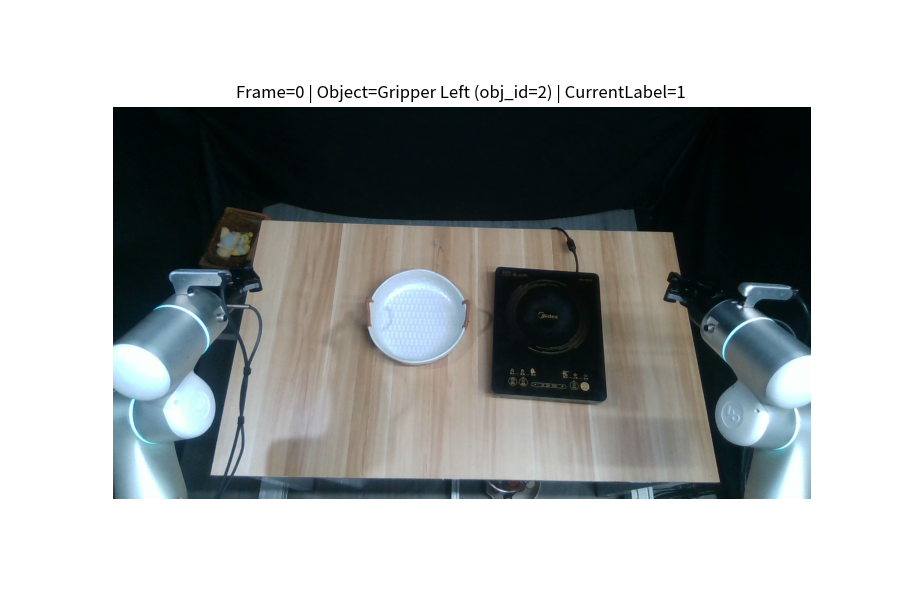

In [5]:
# Gripper 标注 UI

# ============================================================
# Gripper 标注 UI
# 在此处为 gripper_left / gripper_right 添加标注点，然后点击 Export 保存 JSON
# 若已有有效 JSON，可跳过此 cell，直接运行下方的 JSON 加载 cell
# ============================================================

# 仅含 gripper 对象，不含 arm（arm 无需标注）
GRIPPER_ANNOTATION_OBJECT_SPECS = {
    "gripper_left": {
        "display": "Gripper Left",
        "obj_id": int(GRIPPER_LEFT_OBJ_ID),
        "target": "GRIPPER_LEFT_KEYFRAME_PROMPTS",
    },
    "gripper_right": {
        "display": "Gripper Right",
        "obj_id": int(GRIPPER_RIGHT_OBJ_ID),
        "target": "GRIPPER_RIGHT_KEYFRAME_PROMPTS",
    },
}

# 若 JSON 已存在，用它 seed UI（不强制加载，仅用于填充初始状态）
_seed_prompt_map = {
    "ARM_CABLE_INITIAL_PROMPTS": [],
    "GRIPPER_LEFT_KEYFRAME_PROMPTS": [],
    "GRIPPER_RIGHT_KEYFRAME_PROMPTS": [],
}
if Path(ANNOTATION_JSON_PATH).exists():
    try:
        _existing = load_annotation_prompts_json(
            json_path=ANNOTATION_JSON_PATH, status_prefix="[annotation/seed]"
        )
        _seed_prompt_map.update(_existing)
        print(f"[annotation] seeding UI from existing JSON: {ANNOTATION_JSON_PATH}")
    except Exception as _e:
        print(f"[annotation][warn] could not seed from JSON: {_e}")

_annotation_store = create_annotation_store(GRIPPER_ANNOTATION_OBJECT_SPECS)
seed_store_from_prompt_map(
    store=_annotation_store,
    object_specs=GRIPPER_ANNOTATION_OBJECT_SPECS,
    prompt_map=_seed_prompt_map,
    img_w=IMG_WIDTH,
    img_h=IMG_HEIGHT,
)

# Export 回调：补齐 ARM_CABLE_INITIAL_PROMPTS 字段后自行保存 JSON。
# 注意：必须用 save_json_on_export=False 禁用 create_annotation_ui 的内部保存，
# 因为内部保存会在添加 ARM 字段之前就调用 validate_export_prompt_map，导致 KeyError。
_gripper_export_result = {}

def _on_gripper_export(export_prompts):
    global _gripper_export_result
    # 补齐 ARM_CABLE_INITIAL_PROMPTS，满足 JSON schema 要求
    _gripper_export_result = {
        "ARM_CABLE_INITIAL_PROMPTS": [],
        "GRIPPER_LEFT_KEYFRAME_PROMPTS": export_prompts.get("GRIPPER_LEFT_KEYFRAME_PROMPTS", []),
        "GRIPPER_RIGHT_KEYFRAME_PROMPTS": export_prompts.get("GRIPPER_RIGHT_KEYFRAME_PROMPTS", []),
    }
    from annotation_ui_tools import save_annotation_prompts_json as _save_json
    _save_json(
        export_prompts=_gripper_export_result,
        json_path=ANNOTATION_JSON_PATH,
        status_prefix="[annotation/gripper]",
    )
    print(f"[annotation] saved to {ANNOTATION_JSON_PATH}")

_annotation_ui = create_annotation_ui(
    video_frames_for_vis=video_frames_for_vis,
    total_frames=TOTAL_FRAMES,
    img_width=IMG_WIDTH,
    img_height=IMG_HEIGHT,
    object_specs=GRIPPER_ANNOTATION_OBJECT_SPECS,
    annotation_store=_annotation_store,
    on_export=_on_gripper_export,
    auto_display=True,
    status_prefix="[annotation/gripper]",
    export_json_path=ANNOTATION_JSON_PATH,
    save_json_on_export=False,  # 禁用内部保存，由 _on_gripper_export 回调负责
)

if not _annotation_ui.get("widget_ready", False):
    print(f"[annotation][fallback] Widget not available: {_annotation_ui.get('widget_error')}")
    print(f"[annotation][fallback] 请直接编辑 JSON 文件: {ANNOTATION_JSON_PATH}")

In [ ]:
# Gripper 分割

# ============================================================
# 从 JSON 加载并校验 Gripper 标注
# 运行此 cell 前请确认已通过标注 UI 导出 JSON（或手动编辑好 JSON）
# ============================================================

print(f"[session2/gripper] loading annotation from JSON: {ANNOTATION_JSON_PATH}")

try:
    annotation_prompts = load_annotation_prompts_json(
        json_path=ANNOTATION_JSON_PATH, status_prefix="[session2/gripper]"
    )
except FileNotFoundError as _e:
    raise RuntimeError(
        f"[session2/gripper][FATAL] JSON not found: {ANNOTATION_JSON_PATH}\n"
        "请先在标注 UI 中点击 Export Prompts 导出 JSON。"
    ) from _e
except Exception as _e:
    raise RuntimeError(f"[session2/gripper][FATAL] 读取 JSON 失败: {_e}") from _e

gripper_left_prompts_norm = validate_and_normalize_prompt_list(
    annotation_prompts.get("GRIPPER_LEFT_KEYFRAME_PROMPTS", []),
    total_frames=TOTAL_FRAMES,
    img_w=IMG_WIDTH,
    img_h=IMG_HEIGHT,
    tag="GRIPPER_LEFT_KEYFRAME_PROMPTS",
    allow_empty=True,
)
gripper_right_prompts_norm = validate_and_normalize_prompt_list(
    annotation_prompts.get("GRIPPER_RIGHT_KEYFRAME_PROMPTS", []),
    total_frames=TOTAL_FRAMES,
    img_w=IMG_WIDTH,
    img_h=IMG_HEIGHT,
    tag="GRIPPER_RIGHT_KEYFRAME_PROMPTS",
    allow_empty=True,
)

# 至少一侧必须有标注
if len(gripper_left_prompts_norm) == 0 and len(gripper_right_prompts_norm) == 0:
    raise RuntimeError(
        "[session2/gripper][FATAL] GRIPPER_LEFT 和 GRIPPER_RIGHT 均无标注点。\n"
        "请在标注 UI 中为至少一侧 gripper 添加点位并重新导出。"
    )

# 校验 obj_id 与配置一致
for _p in gripper_left_prompts_norm:
    if _p["obj_id"] != GRIPPER_LEFT_OBJ_ID:
        raise ValueError(
            f"[session2/gripper] GRIPPER_LEFT prompt obj_id={_p['obj_id']} "
            f"!= GRIPPER_LEFT_OBJ_ID={GRIPPER_LEFT_OBJ_ID}。请检查 JSON 或配置。"
        )
for _p in gripper_right_prompts_norm:
    if _p["obj_id"] != GRIPPER_RIGHT_OBJ_ID:
        raise ValueError(
            f"[session2/gripper] GRIPPER_RIGHT prompt obj_id={_p['obj_id']} "
            f"!= GRIPPER_RIGHT_OBJ_ID={GRIPPER_RIGHT_OBJ_ID}。请检查 JSON 或配置。"
        )

_left_frames = sorted({p["frame_index"] for p in gripper_left_prompts_norm})
_right_frames = sorted({p["frame_index"] for p in gripper_right_prompts_norm})
print(f"[session2/gripper] left  prompt entries={len(gripper_left_prompts_norm)}  keyframes={_left_frames}")
print(f"[session2/gripper] right prompt entries={len(gripper_right_prompts_norm)}  keyframes={_right_frames}")
print("[session2/gripper] validation passed. Ready for Session 2.")

# ============================================================
# Session 2 — Gripper 分割
# 全新 predictor，先 text bootstrap 填充缓存，再加 gripper 标注点
#
# 为什么需要 text bootstrap？
#   SAM3 的 add_tracker_new_points（点标注路径）要求 cached_frame_outputs 已存在。
#   必须先跑一次 propagation 才能加点标注。Session 2 从零开始所以需要先 bootstrap。
#   bootstrap 使用与 Session 1 相同的 ARM_TEXT_PROMPT 仅用于初始化缓存。
#   最终 merge 时只从 outputs_gripper 提取 gripper obj_ids，arm 部分被忽略。
#   Session 1 的 arm 分割完全独立，不受任何影响。
# ============================================================

print("[session2/gripper] initializing fresh predictor (independent of Session 1) ...")
gpus_to_use = range(torch.cuda.device_count())
predictor_gripper = build_sam3_video_predictor(
    checkpoint_path=CHECKPOINT_PATH,
    gpus_to_use=gpus_to_use,
    apply_temporal_disambiguation=APPLY_TEMPORAL_DISAMBIGUATION,
)

start_response = predictor_gripper.handle_request(
    request=dict(type="start_session", resource_path=VIDEO_PATH)
)
session_id_gripper = start_response["session_id"]
print(f"[session2/gripper] session started: session_id={session_id_gripper}")

# ----------------------------------------------------------
# Step 1: Text bootstrap + 传播以填充缓存
# add_tracker_new_points 要求 cached_frame_outputs 已存在，必须先 propagate
# ----------------------------------------------------------
print(f"[session2/gripper] bootstrapping cache: frame={ARM_TEXT_BOOTSTRAP_FRAME_INDEX}  prompt={ARM_TEXT_PROMPT!r}")
add_text_prompt(
    predictor_obj=predictor_gripper,
    session_id_value=session_id_gripper,
    frame_index=ARM_TEXT_BOOTSTRAP_FRAME_INDEX,
    text_prompt=ARM_TEXT_PROMPT,
    stage_name="session2/bootstrap",
)
print("[session2/gripper] propagating to fill cache (bootstrap pass) ...")
_outputs_bootstrap = propagate_bidirectional_and_merge(
    predictor_obj=predictor_gripper,
    session_id_value=session_id_gripper,
    stage_name="session2/bootstrap",
)
print(f"[session2/gripper] cache populated ({len(_outputs_bootstrap)} frames)")

# ----------------------------------------------------------
# Step 2: 添加 gripper 标注点（缓存已就绪）
# ----------------------------------------------------------
if len(gripper_left_prompts_norm) > 0:
    print(f"[session2/gripper] applying {len(gripper_left_prompts_norm)} left gripper prompt entries ...")
    apply_prompt_list(
        predictor_obj=predictor_gripper,
        session_id_value=session_id_gripper,
        prompt_list=gripper_left_prompts_norm,
        stage_name="session2/gripper_left",
    )
else:
    print("[session2/gripper] no left gripper prompts (skipping)")

if len(gripper_right_prompts_norm) > 0:
    print(f"[session2/gripper] applying {len(gripper_right_prompts_norm)} right gripper prompt entries ...")
    apply_prompt_list(
        predictor_obj=predictor_gripper,
        session_id_value=session_id_gripper,
        prompt_list=gripper_right_prompts_norm,
        stage_name="session2/gripper_right",
    )
else:
    print("[session2/gripper] no right gripper prompts (skipping)")

# ----------------------------------------------------------
# Step 3: 最终双向传播
# ----------------------------------------------------------
print("[session2/gripper] final propagation (bidirectional) ...")
outputs_gripper = propagate_bidirectional_and_merge(
    predictor_obj=predictor_gripper,
    session_id_value=session_id_gripper,
    stage_name="session2/gripper",
)
print(f"[session2/gripper] propagation done: {len(outputs_gripper)} frames")

# 校验 gripper obj_id 在输出中存在
_gripper_ids_found = set()
for _fo in outputs_gripper.values():
    for _oid, _ in iter_object_masks_from_frame_output(_fo):
        _gripper_ids_found.add(int(_oid))
print(f"[session2/gripper] obj_ids in outputs: {sorted(_gripper_ids_found)}")

_expected_gripper_ids = set()
if len(gripper_left_prompts_norm) > 0:
    _expected_gripper_ids.add(GRIPPER_LEFT_OBJ_ID)
if len(gripper_right_prompts_norm) > 0:
    _expected_gripper_ids.add(GRIPPER_RIGHT_OBJ_ID)
_missing = _expected_gripper_ids - _gripper_ids_found
if _missing:
    raise ValueError(
        f"[session2/gripper][FATAL] Expected obj_ids {_missing} not in outputs. "
        f"Check annotation point quality and keyframe positions."
    )

# 关闭 Session 2；outputs_gripper 保留在内存供 Merge 使用
# merge 时只提取 gripper obj_ids（arm 的 obj_id=0 会被过滤掉）
print("[session2/gripper] shutting down predictor ...")
cleanup_resources(predictor_obj=predictor_gripper, session_id_value=session_id_gripper)
predictor_gripper = None
session_id_gripper = None
print(f"[session2/gripper] done. outputs_gripper preserved ({len(outputs_gripper)} frames).")

# ============================================================
# Checkpoint: 将 gripper union masks 保存到磁盘（已过滤 gripper obj_ids）
# 作用：若 Session 1 卡死需重启，可从 checkpoint 加载 gripper 结果，跳过重跑 Session 2
# ============================================================
print(f"[ckpt/gripper] saving pre-dilate gripper masks → {CHECKPOINT_GRIPPER_DIR}")
os.makedirs(CHECKPOINT_GRIPPER_DIR, exist_ok=True)
_ckpt_w, _ckpt_h = get_frame_size(video_frames_for_vis)
_ckpt_gripper_set = set()
if len(gripper_left_prompts_norm) > 0:
    _ckpt_gripper_set.add(GRIPPER_LEFT_OBJ_ID)
if len(gripper_right_prompts_norm) > 0:
    _ckpt_gripper_set.add(GRIPPER_RIGHT_OBJ_ID)
for _ckpt_fi in range(TOTAL_FRAMES):
    _ckpt_u = np.zeros((_ckpt_h, _ckpt_w), np.uint8)
    for _ckpt_oid, _ckpt_m in iter_object_masks_from_frame_output(outputs_gripper.get(_ckpt_fi, {})):
        if int(_ckpt_oid) not in _ckpt_gripper_set:
            continue
        if isinstance(_ckpt_m, torch.Tensor):
            _ckpt_m = _ckpt_m.detach().cpu().numpy()
        if _ckpt_m.ndim > 2:
            _ckpt_m = np.squeeze(_ckpt_m)
        _ckpt_u = np.maximum(_ckpt_u, (_ckpt_m > 0).astype(np.uint8) * 255)
    Image.fromarray(_ckpt_u, "L").save(os.path.join(CHECKPOINT_GRIPPER_DIR, f"{_ckpt_fi:05d}.png"))
print(f"[ckpt/gripper] done: {TOTAL_FRAMES} frames → {CHECKPOINT_GRIPPER_DIR}")

# ============================================================
# 可视化 Session 2 gripper 结果
# 检查 gripper 掩膜质量，若不满意请修改标注点并重新运行 Session 2
# ============================================================
visualize_outputs(
    outputs_per_frame=outputs_gripper,
    video_frames=video_frames_for_vis,
    stride=VIS_FRAME_STRIDE,
    max_plots=VIS_MAX_PLOTS,
    title="Session 2: Gripper Segmentation (annotation points only)",
)

INFO 2026-02-26 23:28:02,442 3366718 sam3_video_predictor.py: 300: using the following GPU IDs: [0, 1, 2, 3]
INFO 2026-02-26 23:28:02,444 3366718 sam3_video_predictor.py: 316: 


	*** START loading model on all ranks ***


INFO 2026-02-26 23:28:02,445 3366718 sam3_video_predictor.py: 318: loading model on rank=0 with world_size=4 -- this could take a while ...


[session2/gripper] loading annotation from JSON: /data/haoxiang/data/airexo2/task_0013/train/scene_0005/cam_105422061350/annotation_prompts_gripper_points.json
[session2/gripper] JSON 读取成功: /data/haoxiang/data/airexo2/task_0013/train/scene_0005/cam_105422061350/annotation_prompts_gripper_points.json
[session2/gripper] JSON created_at_utc: 2026-02-26T15:22:22.057073+00:00
[session2/gripper] 对象条目统计: {'ARM_CABLE_INITIAL_PROMPTS': 0, 'GRIPPER_LEFT_KEYFRAME_PROMPTS': 4, 'GRIPPER_RIGHT_KEYFRAME_PROMPTS': 4, 'ARM_CABLE_2_INITIAL_PROMPTS': 0}
[session2/gripper] 对象点数统计: {'ARM_CABLE_INITIAL_PROMPTS': 0, 'GRIPPER_LEFT_KEYFRAME_PROMPTS': 7, 'GRIPPER_RIGHT_KEYFRAME_PROMPTS': 7, 'ARM_CABLE_2_INITIAL_PROMPTS': 0}
[session2/gripper] 按对象逐帧点数统计: {'ARM_CABLE_INITIAL_PROMPTS': {}, 'GRIPPER_LEFT_KEYFRAME_PROMPTS': {0: 1, 60: 2, 120: 2, 240: 2}, 'GRIPPER_RIGHT_KEYFRAME_PROMPTS': {0: 1, 60: 2, 120: 2, 240: 2}, 'ARM_CABLE_2_INITIAL_PROMPTS': {}}
[session2/gripper] 含标注帧数: 4
[session2/gripper] left  prompt entr

INFO 2026-02-26 23:28:11,895 3366718 sam3_video_base.py: 125: setting max_num_objects=10000 and num_obj_for_compile=16
INFO 2026-02-26 23:28:15,780 3366718 sam3_video_predictor.py: 320: loading model on rank=0 with world_size=4 -- DONE locally
INFO 2026-02-26 23:28:15,781 3366718 sam3_video_predictor.py: 377: spawning 3 worker processes
/home/haoxiang/sam3/sam3/model_builder.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/home/haoxiang/sam3/sam3/model_builder.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/home/haoxiang/sam3/sam3/model_builder.py

In [ ]:
# 清理

# ============================================================
# 防御性清理（重复运行或异常中断后确保资源释放）
# ============================================================

if predictor_gripper is not None:
    print('[cleanup] cleaning gripper predictor (not yet cleaned)')
    cleanup_resources(predictor_obj=predictor_gripper, session_id_value=session_id_gripper)
    predictor_gripper = None
    session_id_gripper = None
else:
    print('[cleanup] predictor_gripper already cleaned')

cleanup_process_group()
print('[cleanup] all resources released')
